# Testat

In [375]:
import os
import skimage
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import util
from skimage.filters import threshold_otsu
from skimage.transform import hough_line, hough_line_peaks

### 1. Load Image, resize and convert

Text(0.5, 1.0, '4.jpg')

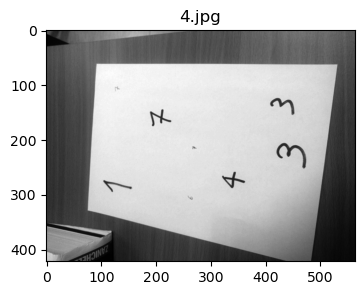

In [556]:
directory = "examples"
files = os.listdir(directory)
files = [files[4]] # comment this out if more than one file

imgs = []
for file in files:
    img = skimage.io.imread(os.path.join(directory, file), as_gray=True)
    img = skimage.exposure.adjust_gamma(img, 2)
    imgs.append(img)

img = imgs[0]
plt.imshow(img, cmap="gray")
plt.title(file)

### 2. Canny edge detector

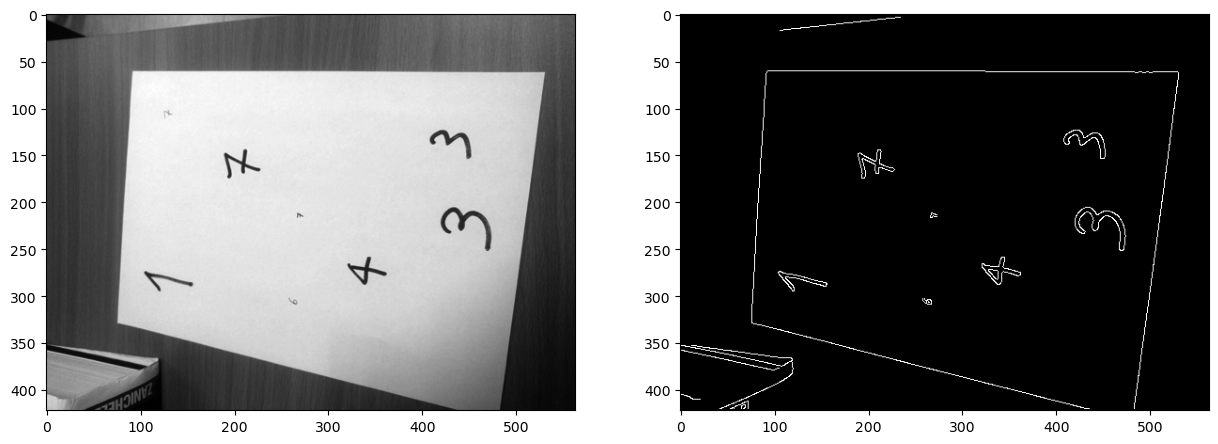

In [557]:
sigma = 0.5
low = 0.3
high = 0.7

imgs_edges = []
for img in imgs:
    imgs_edges.append(skimage.feature.canny(img, sigma=sigma, low_threshold=low, high_threshold=high))

im_edges = imgs_edges[0]
fig, axs = plt.subplots(ncols=2, figsize=(15,10))
axs[0].imshow(img, cmap="gray")
axs[1].imshow(im_edges, cmap="gray")

### 3. Hough line detector

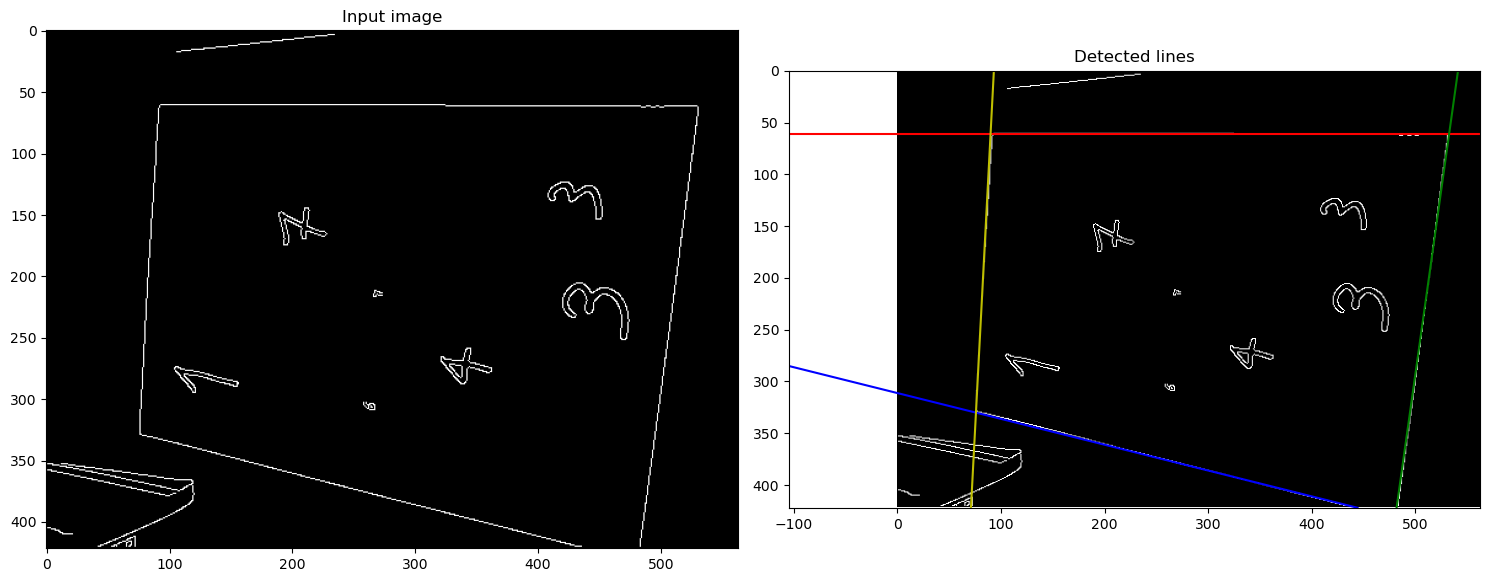

In [558]:
plot = True
for img in imgs_edges:
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        ax = axes.ravel()

        ax[0].imshow(img, cmap="gray")
        ax[0].set_title('Input image')
        ax[1].imshow(img, cmap="gray")
        ax[1].set_ylim((img.shape[0], 0))
        ax[1].set_title('Detected lines')


    xs = []
    ys = []
    slopes = []
    bs = []
    colors = ["r", "g", "b", "y"]

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        i = len(xs)
        xs.append(x0)
        ys.append(y0)
        slope = np.tan(angle + np.pi/2)
        slopes.append(slope)
        bs.append(y0 - slope * x0)
        if plot:
            ax[1].axline((x0, y0), slope=slope, color=colors[i])
            
    plt.tight_layout()
    plt.show()
    plot = False

### 4. Find intersections

In [559]:
def line_intersect(m1, b1, m2, b2):
    x = int((b2 - b1) / (m1 - m2))
    y = int(m1 * x + b1)
    return x, y

[(532, 61), (89, 61), (480, 435), (75, 329)]


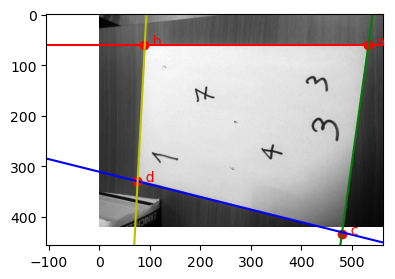

In [560]:
plot = True
for img in imgs:
    points = []

    pairs = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4)] # all possible intersecions

    for pair in pairs:
        i = pair[0] - 1
        k = pair[1] - 1
        xt, yt = line_intersect(slopes[i], bs[i], slopes[k], bs[k])
        # ignore intersections that are far away, probably intersection between top+bottom or left+right
        if xt < 1.2 * img.shape[1] and yt < 1.2 * img.shape[0] and xt > 0 and yt > 0:
            points.append((xt, yt))
    if plot:
        plt.imshow(img, cmap="gray")

        labels = ["  a", "  b", "  c", "  d"]
        for i in range(len(xs)):
            plt.scatter(points[i][0], points[i][1], marker='o', color='r')
            plt.text(points[i][0], points[i][1], labels[i], color='r')
            plt.axline((xs[i], ys[i]), slope=slopes[i], color=colors[i])
        print(points)
    plot = False

### 5. Geometric transformation

In [561]:
# get long / short lines
def get_dist(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

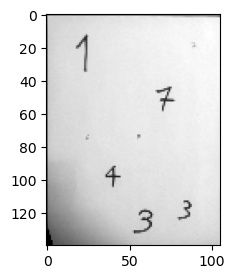

In [562]:
tims = []

for img in imgs:

    tl = (0, 0)
    tr = (img.shape[1], 0)
    br = (img.shape[1], img.shape[0])
    bl = (0, img.shape[0])

    corner_dict = {
        "top_left": tl,
        "top_right": tr,
        "bottom_right": br,
        "bottom_left": bl
    }

    for k, v in corner_dict.items():
        distances = []
        for point in points:
            distances.append(get_dist(v, point))
            corner_dict[k] = points[np.argmin(distances)]
    top_dist = get_dist(corner_dict["top_left"], corner_dict["top_right"])
    left_dist = get_dist(corner_dict["top_left"], corner_dict["bottom_left"])
    right_dist = get_dist(corner_dict["top_right"], corner_dict["bottom_right"])
    bottom_dist = get_dist(corner_dict["bottom_left"], corner_dict["bottom_right"])

    if top_dist < left_dist:
        # paper is in correct orientation
        w,h = image.shape[1], image.shape[0] # keep original w and h
        invtf = skimage.transform.estimate_transform("projective", 
                                                     src=np.vstack((tl,tr,bl,br)), 
                                                     dst=np.vstack((corner_dict["top_left"], 
                                                                    corner_dict["top_right"], 
                                                                    corner_dict["bottom_left"], 
                                                                    corner_dict["bottom_right"] )))
    else:
        # paper is not in correct orientation, rotate
        a = np.array(corner_dict["top_left"])
        b = np.array(corner_dict["top_right"])
        c = np.array(corner_dict["bottom_right"])
        d = np.array(corner_dict["bottom_left"])

        w,h = image.shape[0], image.shape[1] # switch w and h of original img

        A = np.array([w, 0]) # top right
        B = np.array([w, h]) # bottom right
        C = np.array([0, h]) # bottom left
        D = np.array([0, 0]) # top left
        invtf = skimage.transform.estimate_transform("projective",
                                                     src=np.vstack((A,B,C,D)),
                                                     dst=np.vstack((a,b,c,d))
                                                    )
        tim = skimage.transform.warp(image=img, inverse_map=invtf, output_shape=(h, w))
        tims.append(tim)

plt.imshow(tims[0], cmap="gray")

### 6. Binarize and find connected components

Unique values in labels: [0 1 2 3 4 5 6 7 8 9]


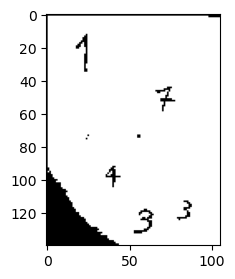

In [572]:
labels = []
binaries = []
for tim in tims:
    thresh = threshold_otsu(tim)
    binary = tim > thresh
    label = skimage.measure.label(binary, background=1)
    labels.append(label)
    binaries.append(binary)

print("Unique values in labels:", np.unique(labels[0]))
plt.imshow(binaries[0], cmap="gray")

### 7. Draw bounding boxes and crop nrs

In [573]:
large_regions = []
min_size = w / 10 
max_size = w + h * 2
for label in labels:
    regions = skimage.measure.regionprops(label)
    large_region = [r for r in regions if r.area > min_size and r.area < max_size]
    large_regions.append(large_region)

print(f"There are {len(large_regions[0])} large regions in the first image")

There are 5 large regions in the first image


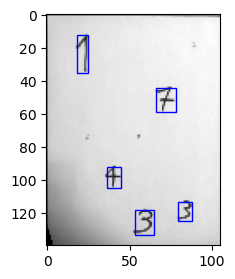

In [574]:
nrs = {}
plot = True
for i in range(len(tims)):
    nrs[i] = []
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(tims[i], cmap="gray")
    for r in large_regions[i]:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row),width,height,
                                 linewidth=1,edgecolor='b',facecolor='none')
        nrs[i].append(tims[i][min_row:max_row, min_col:max_col])
        if plot:
            ax.add_patch(rect)
    plot = False

#### Preprocessing and Classification

In [576]:
import torch

class MLP(torch.nn.Module):
    
    def __init__(self, units, activation_class = None):
        super().__init__()
        self.layers = []
        for i in range(len(units)-2):
            self.layers.append(torch.nn.Linear(units[i], units[i+1]))
            self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(units[len(units)-2], units[len(units)-1]))
        print([layer for layer in self.layers])
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            *self.layers
        )
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model = MLP([28*28, 100, 500, 10])
model.load_state_dict(torch.load("mnist-classifier.pt"))
model.eval()

[Linear(in_features=784, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=500, bias=True), ReLU(), Linear(in_features=500, out_features=10, bias=True)]


MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=500, bias=True)
    (4): ReLU()
    (5): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [577]:
results = {}
nrs_preprocessed = {}
values = {}
preds = {}

for i in range(len(tims)):
    results[i] = []
    nrs_preprocessed[i] = []
    values[i] = []
    preds[i] = []

    for nr in nrs[i]:
        # switch background and foreground for mnist
        nr = util.invert(nr) 
        # resize image to mach input dim (1,28,28)
        nr = skimage.transform.resize(nr, (28, 28), anti_aliasing=False)
        nrs_preprocessed[i].append(nr)
        # convert to tensor
        nr = torch.from_numpy(nr)
        # append channel dimension
        nr = torch.unsqueeze(nr, 0).to(torch.float32)
        # get prediction
        pred = model(nr)
        idx = torch.argmax(pred, dim=1).item()
        conf = np.round(torch.max(pred, dim=1).values.item(), 2)
        values[i].append(conf)
        if conf < 3:
            # we are not sure about the prediction
            results[i].append("-")
        else:
            results[i].append(idx)

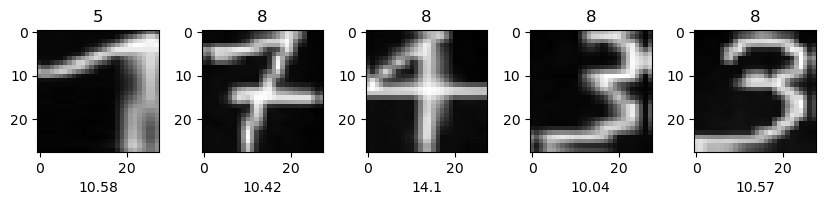

In [578]:
plt.rcParams["figure.figsize"] = (10,3)

l = len(nrs[0])
for i in range(l):
    plt.subplot(1, l+1, i+1)
    plt.imshow(nrs_preprocessed[0][i], cmap="gray")
    plt.title(results[0][i])
    plt.xlabel(values[0][i])
    #plt.axis('off')
plt.tight_layout()

In [585]:
test = skimage.io.imread("test6.png", as_gray=True)

In [586]:
test = skimage.transform.resize(test, (28, 28), anti_aliasing=False)
# convert to tensor
test = torch.from_numpy(test)
# append channel dimension
test = torch.unsqueeze(test, 0).to(torch.float32)
# get prediction
pred = model(test)